# Geophysics 3 Group Project
## Flow over hills

Topography files `hill.txt` and `ridge.txt` are preloaded in this folder. Each contains a 512x512 grid of point elevations given by
$$
z_{ij}=\frac{100}{1 + (r_{ij}/50)^2}
$$
with $r_{ij} = |i|$ for a ridge or $r_{ij} = \sqrt{i^2 + j^2}$ for a hill (-256 $<i,j<$ 255).

Run the next cell to set parameters for the linear wind model:

In [1]:
# Parameters
topo_file = 'hill.txt'       # Topography file name
dx = 10.                     # Grid spacing (m)
L  = 1000.                   # Horizontal length scale (m)
z0 = 0.01                    # Surface roughness length (m)
zu = 2.                      # Wind measurement height (m)

Run the next cell for a simulation with 1 m s$^{-1}$ wind from the west:

In [2]:
"""
Linear model for turbulent flow over low hills derived
from Jackson and Hunt (1975), Mason and Sykes (1979)
"""
import numpy as np
from scipy.fftpack import fft2,fftshift,ifft2,ifftshift
from scipy.special import kv

# Iteration to find the inner region thickness l (m)
l = (z0/8)*(L/z0)**0.9
for i in range(10):
    l = 2*0.16*L/np.log(l/z0)
a = (np.log(L/z0))**2/(np.log(l/z0)*np.log(zu/z0))

# Read the topography file, find size and take a Fourier transform
z = np.loadtxt(topo_file)
n = z.shape[0]
Fz = fft2(z)
Fz = fftshift(Fz)

# Wavenumbers and modified Bessel functions
k = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)       
m = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)
bu = 1 - kv(0,2*np.sqrt(1j*L*k*zu/l))/kv(0,2*np.sqrt(1j*L*k*z0/l))
bv = 1 - kv(0,2*np.sqrt(2*1j*L*k*zu/l))/kv(0,2*np.sqrt(2*1j*L*k*z0/l))
bu[int(n/2)] = 0
bv[int(n/2)] = 0

# Fourier components of u and v
Fu = np.zeros_like(Fz)
Fv = np.zeros_like(Fz)
for i in range(n):
    for j in range(n):
        r = np.sqrt(k[j]**2 + m[i]**2)
        if r != 0:
            Fu[i,j] = a*bu[j]*(k[j]**2/r)*Fz[i,j]
            Fv[i,j] = a*bv[j]*(k[j]*m[i]/r)*Fz[i,j]

# Inverse Fourier transform
Fu = ifftshift(Fu)
Fv = ifftshift(Fv)
u = 1 + np.real(ifft2(Fu))
v = np.real(ifft2(Fv))
wind = np.sqrt(u**2 + v**2)

C:\Users\noraf\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
C:\Users\noraf\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


Run the next cell for a basic visualization of the wind field:

In [3]:
import matplotlib.pyplot as plt
plt.imshow(wind)
plt.colorbar()

Here are some things you could try:

Plot wind speed `wind[256,:]` over the top of the hill and compare it with wind speed over the ridge.

Plot the wind field over the hill as vectors or streamlines.

https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/quiver_simple_demo.html#sphx-glr-gallery-images-contours-and-fields-quiver-simple-demo-py

https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/plot_streamplot.html#sphx-glr-gallery-images-contours-and-fields-plot-streamplot-py

Plot the topography as a contour map, a shaded relief map or a surface.

https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/contour_demo.html#sphx-glr-gallery-images-contours-and-fields-contour-demo-py

https://matplotlib.org/examples/pylab_examples/shading_example.html

https://matplotlib.org/examples/mplot3d/surface3d_demo.html

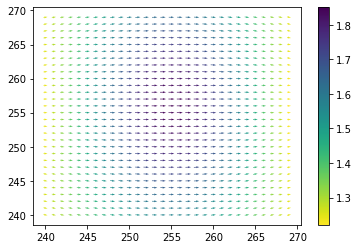

In [4]:
# Wind vector plot over hill

import numpy as np
import matplotlib.pyplot as plt
X = np.arange(0, 512)
Y = np.arange(0, 512)

fig, ax = plt.subplots()
q = ax.quiver(X[240:270], Y[240:270], u[240:270, 240:270], v[240:270, 240:270], wind[240:270, 240:270], cmap='viridis_r', pivot='mid', units='inches')
fig.colorbar(q)

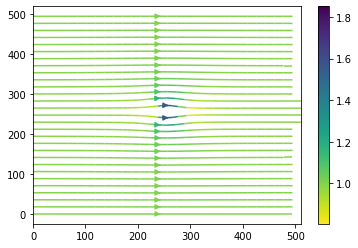

In [5]:
# Wind stream lines over hill

fig, ax = plt.subplots()
strm = ax.streamplot(X, Y, u, v, color=wind, cmap='viridis_r')
fig.colorbar(strm.lines)

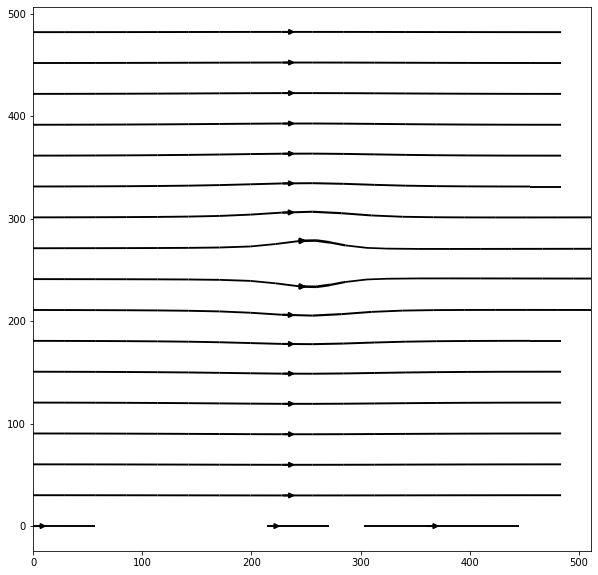

In [6]:
# Vary wind stream linewidth with wind speed

# simple model
Y, X = np.mgrid[0:512, 0:512]
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot()
#lw = 5*wind / wind.max()
lw = 2*wind / (wind.max()-wind.min())


ax.streamplot(X, Y, u, v, density=0.6, color='k', linewidth=lw)

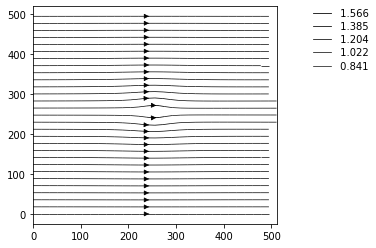

In [7]:
# More sophisticated model for varying stream linewidth with wind speed
import matplotlib.gridspec as gridspec

Y, X = np.mgrid[0:512, 0:512]

# Create figure
fig = plt.figure()

# Create axes, ax for your plot, and lx for the legend
gs = gridspec.GridSpec(2, 2, height_ratios=(1,2), width_ratios=(4,1))
ax = fig.add_subplot(gs[:, 0])
lx = fig.add_subplot(gs[0, 1])

def windToLW(wind):
    ''' 
    Function to convert windspeed into a sensible linewidth
    '''
    return 0.5 + wind / 5.

def LWToSpeed(lw):
    ''' The inverse of windToLW, to get the speed back from the linewidth '''
    return (lw - 0.5) * 5.

def makeStreamLegend(strm, lx, convertFunc, nlines=5, color='k', fmt='{:g}'):

    ''' Make a legend for a streamplot on a separate axes instance '''

    # Get the linewidths from the streamplot LineCollection
    lws = np.array(strm.lines.get_linewidths())

    # Turn off axes lines and ticks, and set axis limits
    lx.axis('off')
    lx.set_xlim(0, 1)
    lx.set_ylim(0, 1)

    # Loop over the desired number of lines in the legend
    for i, y in enumerate(np.linspace(0.1, 0.9, nlines)):

        # This linewidth
        lw = lws.min()+float(i) * lws.ptp()/float(nlines-1)
        
        # Plot a line in the legend, of the correct length
        lx.axhline(y, 0.1, 0.4, c=color, lw=lw)

        # Add a text label, after converting the lw back to a speed
        lx.text(0.5, y, fmt.format(convertFunc(lw)), va='center')

# Make the stream plot
strm = ax.streamplot(X, Y, u, v, color="k", linewidth=windToLW(wind))

# Add a legend, with 5 lines
makeStreamLegend(strm, lx, LWToSpeed, nlines=5, fmt='{:6.3f}')

plt.show()

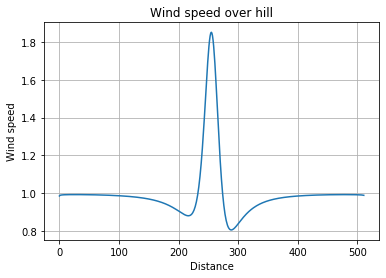

In [8]:
# Wind speed over top of hill

plt.plot(wind[256,:])
plt.title("Wind speed over hill")
plt.xlabel("Distance")
plt.ylabel("Wind speed")
plt.grid()

In [9]:
## For ridge data

topo_file = 'ridge.txt'  
"""
Linear model for turbulent flow over low hills derived
from Jackson and Hunt (1975), Mason and Sykes (1979)
"""
import numpy as np
from scipy.fftpack import fft2,fftshift,ifft2,ifftshift
from scipy.special import kv

# Iteration to find the inner region thickness l (m)
l = (z0/8)*(L/z0)**0.9
for i in range(10):
    l = 2*0.16*L/np.log(l/z0)
a = (np.log(L/z0))**2/(np.log(l/z0)*np.log(zu/z0))

# Read the topography file, find size and take a Fourier transform
z = np.loadtxt(topo_file)
n = z.shape[0]
Fz = fft2(z)
Fz = fftshift(Fz)

# Wavenumbers and modified Bessel functions
k = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)       
m = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)
bu = 1 - kv(0,2*np.sqrt(1j*L*k*zu/l))/kv(0,2*np.sqrt(1j*L*k*z0/l))
bv = 1 - kv(0,2*np.sqrt(2*1j*L*k*zu/l))/kv(0,2*np.sqrt(2*1j*L*k*z0/l))
bu[int(n/2)] = 0
bv[int(n/2)] = 0

# Fourier components of u and v
Fu = np.zeros_like(Fz)
Fv = np.zeros_like(Fz)
for i in range(n):
    for j in range(n):
        r = np.sqrt(k[j]**2 + m[i]**2)
        if r != 0:
            Fu[i,j] = a*bu[j]*(k[j]**2/r)*Fz[i,j]
            Fv[i,j] = a*bv[j]*(k[j]*m[i]/r)*Fz[i,j]

# Inverse Fourier transform
Fu = ifftshift(Fu)
Fv = ifftshift(Fv)
u = 1 + np.real(ifft2(Fu))
v = np.real(ifft2(Fv))
wind = np.sqrt(u**2 + v**2)

C:\Users\noraf\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
C:\Users\noraf\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


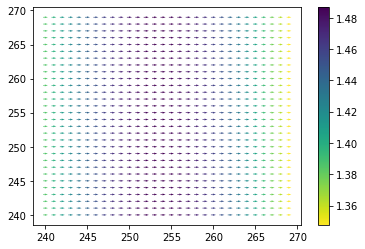

In [10]:
# Wind vectors over ridge

import numpy as np
import matplotlib.pyplot as plt
X = np.arange(0, 512)
Y = np.arange(0, 512)

fig, ax = plt.subplots()
q = ax.quiver(X[240:270], Y[240:270], u[240:270, 240:270], v[240:270, 240:270], wind[240:270, 240:270], cmap='viridis_r', pivot='mid', units='inches')
fig.colorbar(q)

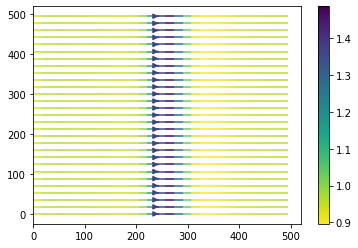

In [11]:
# Wind stream lines over ridge

fig, ax = plt.subplots()
strm = ax.streamplot(X, Y, u, v, color=wind, cmap='viridis_r')
fig.colorbar(strm.lines)

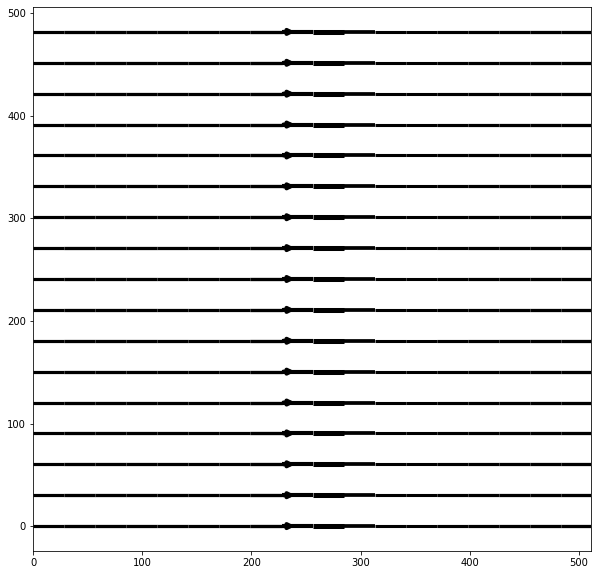

In [12]:
# Vary wind stream linewidth with wind speed

# simple model

#  Varying line width along a streamline
Y, X = np.mgrid[0:512, 0:512]
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot()
#lw = 5*wind / wind.max()
lw = 2*wind / (wind.max()-wind.min())


ax.streamplot(X, Y, u, v, density=0.6, color='k', linewidth=lw)

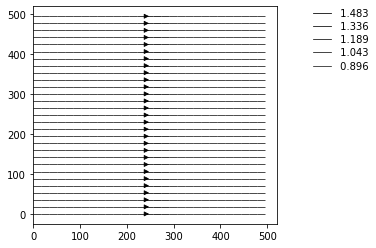

In [13]:
# More sophisticated model for varying stream linewidth with wind speed
import matplotlib.gridspec as gridspec

Y, X = np.mgrid[0:512, 0:512]

# Create you figure
fig = plt.figure()

# Create axes, ax for your plot, and lx for the legend
gs = gridspec.GridSpec(2, 2, height_ratios=(1,2), width_ratios=(4,1))
ax = fig.add_subplot(gs[:, 0])
lx = fig.add_subplot(gs[0, 1])

def windToLW(wind):
    ''' 
    Function to convert windspeed into a sensible linewidth
    This will need to change depending on your data
    '''
    return 0.5 + wind / 5.

def LWToSpeed(lw):
    ''' The inverse of windToLW, to get the speed back from the linewidth '''
    return (lw - 0.5) * 5.

def makeStreamLegend(strm, lx, convertFunc, nlines=5, color='k', fmt='{:g}'):

    ''' Make a legend for a streamplot on a separate axes instance '''

    # Get the linewidths from the streamplot LineCollection
    lws = np.array(strm.lines.get_linewidths())

    # Turn off axes lines and ticks, and set axis limits
    lx.axis('off')
    lx.set_xlim(0, 1)
    lx.set_ylim(0, 1)

    # Loop over the desired number of lines in the legend
    for i, y in enumerate(np.linspace(0.1, 0.9, nlines)):

        # This linewidth
        lw = lws.min()+float(i) * lws.ptp()/float(nlines-1)
        
        # Plot a line in the legend, of the correct length
        lx.axhline(y, 0.1, 0.4, c=color, lw=lw)

        # Add a text label, after converting the lw back to a speed
        lx.text(0.5, y, fmt.format(convertFunc(lw)), va='center')

# Make the stream plot
strm = ax.streamplot(X, Y, u, v, color="k", linewidth=windToLW(wind))

# Add a legend, with 5 lines
makeStreamLegend(strm, lx, LWToSpeed, nlines=5, fmt='{:6.3f}')

plt.show()

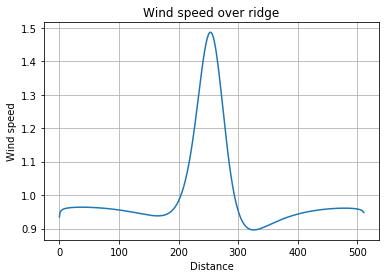

In [14]:
# Wind speed over ridge

plt.plot(wind[256,:])
plt.title("Wind speed over ridge")
plt.xlabel("Distance")
plt.ylabel("Wind speed")
plt.grid()

In [15]:
# cut through hill so plot horizontal and vertical wind vectors in the lee of the hill